In [1]:
from scipy.optimize import linprog
from math import sqrt
from collections import defaultdict
import numpy as np
import random
import copy
import math
import matplotlib.pyplot as plt 
import timeit
import pandas as pd
from scipy import stats
import time

from cvxopt import matrix
from cvxopt.modeling import variable
from cvxopt.modeling import op, dot

random.seed(42)

/Users/Devansh/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# hardcoded constants

num_subjects = 1540 # i
num_treatments = 2 # t
capacity_matrix = [663, 877]
budget = 100
epsilon = 0.1 # has to be less than 0.5
rct_treatment_probabilities = [capacity_matrix[0]*1.0/num_subjects, capacity_matrix[1]*1.0/num_subjects]
budget_matrix = [budget] * num_subjects

# Scaling factor for alpha, beta to set new prices
alpha_scaling_factor = 0.5
beta_scaling_factor = budget/50

In [3]:
# Init alpha, beta assumed to be positive
def init_alpha():
    alpha = [random.randint(-budget, 0) for i in range(num_treatments)]
    return alpha
def init_beta():
    beta = [random.randint(-budget, budget) for i in range(num_treatments)]
    return beta

In [4]:
# Price vector pi(i,t) = alpha(t) * pte(i,t) + beta(t). Dimensions num_subjects * num_treatments
def get_price_matrix(alpha, beta):
    price_matrix = [[(alpha[index] * pte_t + beta[index]) for index, pte_t in enumerate(pte)] for pte in pte_matrix]
    price_matrix = np.array(price_matrix)
    #print "get_price_matrix: Price matrix:", price_matrix
    return price_matrix

In [5]:
# Demand p*(i,t) matrix. Solve LP to get values. Dimensions num_subjects * num_treatments
def get_demand_matrix(price_matrix):
    prob_coefficient = [1] * num_treatments
    prob_sum = 1
    x0_bounds = (epsilon, 1-epsilon)
    x1_bounds = (epsilon, 1-epsilon)
    # dummy first row
    demand_matrix = np.zeros(num_treatments)
    for i in range(num_subjects):
        # Constraints:
        # 1. <p*(i), pi(i)> <= b(i) for every subject i
        # 2. sum of all p*(t) = prob_threshold for every subject i
        coefficients = price_matrix[i]
        thresholds = budget_matrix[i]
        result = linprog(c=-wtp_matrix[i], 
                         # A_ub needs to be 2D array  
                         A_ub=np.stack((coefficients, coefficients)),
                         b_ub=np.stack((thresholds, thresholds)),
                         # A_eq needs to be 2D array
                         A_eq=np.stack((prob_coefficient, prob_coefficient)),
                         b_eq=np.stack((prob_sum, prob_sum)),
                         # bounds = (0,1) for both demand prob.s
                         bounds = (x0_bounds, x1_bounds))
        demand_matrix = np.vstack((demand_matrix, result.x))
    # delete dummy first row
    demand_matrix = np.delete(demand_matrix, (0), axis=0)
    #print "get_demand_matrix: Demand matrix:", demand_matrix
    return demand_matrix

In [6]:
# def get_demand_matrix(price_matrix):
#     # solve LP problem subject by subject
#     demand_matrix = np.zeros((num_subjects, num_treatments))
#     for i in range(num_subjects):
#         p_i0 = variable()
#         p_i1 = variable()

#         objective = wtp_matrix[i][0]*p_i0 + wtp_matrix[i][1]*p_i1
#         budget_constraint = (price_matrix[i][0]*p_i0 + price_matrix[i][1]*p_i1 <= budget_matrix[i])
#         probability_constraint = (p_i0 + p_i1 == 1)
#         b1 = (p_i0 >= epsilon)
#         b2 = (p_i0 <= 1-epsilon)
#         b3 = (p_i1 >= epsilon)
#         b4 = (p_i1 <= 1-epsilon)

#         lp_subject = op(objective, [budget_constraint, probability_constraint, b1, b2, b3, b4])
#         lp_subject.solve()
        
#         demand_matrix[i][0] = p_i0
#         demand_matrix[i][1] = p_i1
#     return demand_matrix

In [7]:
# def get_demand_matrix(price_matrix):
#     A_ub = np.zeros((num_subjects, num_subjects*num_treatments))
#     b_ub = np.zeros(num_subjects)
#     A_eq = np.zeros((num_subjects, num_subjects*num_treatments))
#     b_eq = np.ones(num_subjects)
#     bounds = np.asarray([epsilon, 1-epsilon])
#     c = -wtp_matrix.flatten()
    
#     # set budget constraint
#     for i in range(num_subjects):
#         A_ub[i,i*num_treatments:(i+1)*num_treatments] = price_matrix[i,:]
#         b_ub[i] = budget_matrix[i]

#     # set equality constraints:
#     for i in range(num_subjects):
#         A_eq[i,i*num_treatments:(i+1)*num_treatments] = 1

#     print c
#     print A_ub[0]
#     print A_ub[-1]
#     print b_ub
#     print A_eq
#     print b_eq
    
#     result = linprog(c=c, 
#                      A_ub=A_ub,
#                      b_ub=b_ub,
#                      A_eq=A_eq,
#                      b_eq=b_eq,
#                      bounds = bounds)
#     print result
#     demand_matrix = result.x.reshape((num_subjects, num_treatments))
#     print demand_matrix
    
#     return demand_matrix

In [8]:
# def get_demand_matrix(price_matrix):
#     A_ub = np.zeros((num_subjects+num_treatments, num_subjects*num_treatments))
#     b_ub = np.zeros(num_subjects+num_treatments)
#     A_eq = np.zeros((num_subjects, num_subjects*num_treatments))
#     b_eq = np.ones(num_subjects)
#     bounds = np.asarray([epsilon, 1-epsilon])
#     c = -wtp_matrix.flatten()
    
#     # set budget constraint
#     for i in range(num_subjects):
#         A_ub[i,i*num_treatments:(i+1)*num_treatments] = price_matrix[i,:]
#         b_ub[i] = budget_matrix[i]

#     # set equality constraints:
#     for i in range(num_subjects):
#         A_eq[i,i*num_treatments:(i+1)*num_treatments] = 1

#     # set capacity constraints:
#     for i in range(num_treatments):
#         i_offset = i+num_subjects
#         A_ub[i_offset,i::2] = 1
#         b_ub[i] = capacity_matrix[i]

#     print c
#     print A_ub[0]
#     print A_ub[-1]
#     print b_ub
#     print A_eq
#     print b_eq
    
#     result = linprog(c=c, 
#                      A_ub=A_ub,
#                      b_ub=b_ub,
#                      A_eq=A_eq,
#                      b_eq=b_eq,
#                      bounds = bounds)
#     print result
#     demand_matrix = result.x.reshape((num_subjects, num_treatments))
#     print demand_matrix
    
#     return demand_matrix

In [9]:
# # Demand p*(i,t) matrix. Solve LP to get values. Dimensions num_subjects * num_treatments
# def get_demand_matrix(price_matrix):
#     prob_coefficient = [1] * num_treatments
#     prob_sum = 1
#     x0_bounds = (epsilon, 1-epsilon)
#     x1_bounds = (epsilon, 1-epsilon)
#     # dummy first row
#     demand_matrix = np.zeros(num_treatments)
    
    
    
    
#     for i in range(num_subjects):
#         # Constraints:
#         # 1. <p*(i), pi(i)> <= b(i) for every subject i
#         # 2. sum of all p*(t) = prob_threshold for every subject i
#         coefficients = price_matrix[i]
#         thresholds = budget_matrix[i]
#         result = linprog(c=-wtp_matrix[i], 
#                          # A_ub needs to be 2D array  
#                          A_ub=np.stack((coefficients, coefficients)),
#                          b_ub=np.stack((thresholds, thresholds)),
#                          # A_eq needs to be 2D array
#                          A_eq=np.stack((prob_coefficient, prob_coefficient)),
#                          b_eq=np.stack((prob_sum, prob_sum)),
#                          # bounds = (0,1) for both demand prob.s
#                          bounds = (x0_bounds, x1_bounds))
#         demand_matrix = np.vstack((demand_matrix, result.x))
#     # delete dummy first row
#     demand_matrix = np.delete(demand_matrix, (0), axis=0)
#     #print "get_demand_matrix: Demand matrix:", demand_matrix
#     return demand_matrix

In [10]:
# Treatment_demand(t) = sum of demand(t) across all i. Dimensions 1 * num_treatments
def get_treatment_demand_matrix(demand_matrix):
    treatment_demand_matrix = np.zeros(num_treatments)
    for subject in range(num_subjects):
        for treatment in range(num_treatments):
            treatment_demand_matrix[treatment] += demand_matrix[subject, treatment]
    #print "get_treatment_demand_matrix: Treatment demand matrix:", treatment_demand_matrix
    return treatment_demand_matrix

In [11]:
# Excess_demand(t) = treatment_demand(t) - capacity(t). Dimensions 1 * num_treatments
def get_excess_demand_matrix(treatment_demand_matrix):
    excess_demand_matrix = treatment_demand_matrix - capacity_matrix
    #print "get_excess_demand_matrix: Excess demand matrix:", excess_demand_matrix
    return excess_demand_matrix

In [12]:
# Clearing error in market = sqrt(sum of excess_demand(t)^2 for every treatment t)
def get_clearing_error(excess_demand_matrix):
    # If demand is satisfied everywhere and total capacity > number of subjects, no clearing error
    if all(excess <= 0 for excess in excess_demand_matrix):
        print "get_clearing_error: Market clear, no clearing error!"
        return 0
    else:
        clearing_error = sqrt(sum([excess**2 for excess in excess_demand_matrix]))
        clearing_error = clearing_error / sum(capacity_matrix)
        print "get_clearing_error: Clearing error:", clearing_error
        return clearing_error

In [13]:
# Recalibrate alpha, beta values to set new prices
def get_alpha_new(alpha, excess_demand_matrix):
    alpha_new = alpha + excess_demand_matrix * alpha_scaling_factor
    for (i, a) in enumerate(alpha_new):
        if (a > 0):
            # alpha become +ve, so reset to random initialization
            alpha_new[i] = random.randint(-budget, 0)
    return alpha_new

def get_beta_new(beta, excess_demand_matrix):
    beta_new = beta + excess_demand_matrix * beta_scaling_factor
    return beta_new    

In [14]:
# Find market clearing price vector. The objective is to change alpha and beta values so that we reduce clearing error
def clear_market():
    
    # Initialize market prices and demand
    alpha = init_alpha()
    beta = init_beta()    
    price_matrix = get_price_matrix(alpha, beta)
    demand_matrix = get_demand_matrix(price_matrix)  
        
    excess_demand_matrix = get_excess_demand_matrix(get_treatment_demand_matrix(demand_matrix))
    clearing_error = get_clearing_error(excess_demand_matrix)
    
    # clearing_error_threshold = 0.01*(num_subjects)/(num_treatments)
    
    # clearing error is percentage of total capacity so we want the market to clear at 1%
    clearing_error_threshold = 0.01
    threshold_iterations = 10
    iterations = 0
    minimum_clearing_error = clearing_error
    alpha_star = 0
    beta_star = 0
    
    # Set new prices to clear market
    while True:
        if iterations > threshold_iterations:
            # new search start
            alpha = init_alpha()
            beta = init_beta()
            iterations = 0
            print "new search start"
#             print alpha, beta         
        else:
            # continue down current search
            alpha = get_alpha_new(alpha, excess_demand_matrix)
            beta = get_beta_new(beta, excess_demand_matrix)
        
        price_matrix = get_price_matrix(alpha, beta)
        demand_matrix = get_demand_matrix(price_matrix)
        excess_demand_matrix = get_excess_demand_matrix(get_treatment_demand_matrix(demand_matrix))
        clearing_error = get_clearing_error(excess_demand_matrix)
        
        # Store parameter values for minimum clearing error
        if clearing_error < minimum_clearing_error:
            minimum_clearing_error = clearing_error
            alpha_star = alpha.copy()
            beta_star = beta.copy()
        # cleared the market! 
        if minimum_clearing_error < clearing_error_threshold:
            break
        iterations += 1
    
    print "Minimum clearing error:", minimum_clearing_error
    print "Alpha_star:", alpha_star
    print "Beta star:", beta_star
    return (minimum_clearing_error, alpha_star, beta_star)

In [15]:
def simulate():
    while True: 
        min_error, alpha_star, beta_star = clear_market()
        price_star = get_price_matrix(alpha_star, beta_star)
        demand_star = get_demand_matrix(price_star)
        
        control_probs = [demand_star_i[0] for demand_star_i in demand_star]
        treatment_probs = [demand_star_i[1] for demand_star_i in demand_star]
        
        if (min_error < 0.01):
            print "cleared market!"
            break
    return demand_star

In [ ]:
# dict of form {dataset : demand_star} 
# demand_star is a list of [control_demand, treatment_demand]
# every dataset is mapped to the market clearing probability distribution
demand_dict = {}
# dict of form {dataset : # unique groups} 
num_input_groups_dict = {}
num_output_groups_dict = {}
problem_datasets = []

start_dataset, end_dataset = 1, 50
for d in range(start_dataset, end_dataset):
    # load data
    pte_df = pd.read_csv("data/PTE_"+str(d)+".csv")
    wtp_df = pd.read_csv("data/WTP_"+str(d)+".csv")
    pte_matrix = [[0, i] for i in pte_df['PTE'].values.tolist()]
    wtp_matrix = [[0, i] for i in wtp_df['WTP'].values.tolist()]
    
    # Convert lists to np.array type for computation
    wtp_matrix = np.array(wtp_matrix)
    pte_matrix = np.array(pte_matrix)
    budget_matrix = np.array(budget_matrix)
    capacity_matrix = np.array(capacity_matrix)
    
    # solve market, add to dict
    demand_star = simulate()
    demand_dict[d] = demand_star.tolist()
    
    control_probs = [demand_star_i[0] for demand_star_i in demand_star]
    treatment_probs = [demand_star_i[1] for demand_star_i in demand_star]

    # sanity check 
    # make dictionary to idenitfy subjects with same pte, wtp 
    # {(pte, wtp) : [subject numbers]} -- get groups
    # now make sure that in each group, everyone has the same treatment and control assignment probability
    sanity_dict = defaultdict(list)
    for subject_num in range(len(wtp_matrix)):
        sanity_dict[(wtp_matrix[subject_num][1], pte_matrix[subject_num][1])].append(subject_num)
    num_input_groups_dict[d] = len(sanity_dict)
    
    for group in sanity_dict.values():
        if not all([treatment_probs[group[0]] == treatment_probs[subject_num] for subject_num in group]):
            print "problem"
        if not all([control_probs[group[0]] == control_probs[subject_num] for subject_num in group]):
            print "problem"
    
    # bounds sanity check -- some datasets appear to be problematic
    if (min(control_probs)<epsilon) or (max(control_probs)>1-epsilon) \
        or (min(treatment_probs)<epsilon) or (max(treatment_probs)>1-epsilon):
            problem_datasets.append(d)
            print "bounds are not correct for", d
    
    # count the number of unique values of p_it -- groups of subjects with same demand
    output_groups_dict = defaultdict(list)
    for i, demand_i in enumerate(demand_star):
        output_groups_dict[(demand_i[0], demand_i[1])].append(i)
    num_output_groups_dict[d] = len(output_groups_dict)
        
    print "finished dataset", d

get_clearing_error: Clearing error: 0.186786388693
get_clearing_error: Clearing error: 0.149119676263
get_clearing_error: Clearing error: 0.0366867491096


In [17]:
print num_input_groups_dict

{1: 9, 2: 9, 3: 12, 4: 12, 5: 16, 6: 12, 7: 12, 8: 9, 9: 9, 10: 9, 11: 12, 12: 12, 13: 12, 14: 16, 15: 12}


In [18]:
print num_output_groups_dict

{1: 4, 2: 6, 3: 4, 4: 5, 5: 5, 6: 5, 7: 5, 8: 4, 9: 6, 10: 4, 11: 4, 12: 5, 13: 5, 14: 5, 15: 5}


In [19]:
print problem_datasets

[2, 6, 9]


In [21]:
df_results = pd.DataFrame.from_dict(demand_dict)
df_results.info()
df_results.to_csv('output/df_results')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 15 columns):
1     1540 non-null object
2     1540 non-null object
3     1540 non-null object
4     1540 non-null object
5     1540 non-null object
6     1540 non-null object
7     1540 non-null object
8     1540 non-null object
9     1540 non-null object
10    1540 non-null object
11    1540 non-null object
12    1540 non-null object
13    1540 non-null object
14    1540 non-null object
15    1540 non-null object
dtypes: object(15)
memory usage: 180.5+ KB


In [43]:
def median(lst):
    return np.median(np.array(lst))

def mean(lst):
    return np.mean(np.array(lst))

def make_figure_wtp(rct, exam, name):
    bins = np.linspace(-100, 200, 100)
    plt.hist(rct, bins=bins, label='RCT', normed = 1, alpha=0.5, color='g')
    plt.axvline(mean(rct), color='g', linestyle='dashed', linewidth=1)
    plt.axvline(median(rct), color='g', linestyle='solid', linewidth=1)
    plt.hist(exam, bins=bins, label='ExaM', normed = 1, alpha=0.5, color='b')
    plt.axvline(mean(exam), color='b', linestyle='dashed', linewidth=1)
    plt.axvline(median(exam), color='b', linestyle='solid', linewidth=1)
    plt.xlabel("WTP")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.savefig(name)
    plt.clf()
    
def make_figure_pte(rct, exam, name):
    bins = np.linspace(-0.10, 0.05, 50)
    plt.hist(rct, bins=bins, label='RCT', normed = 1, alpha=0.5, color='g')
    plt.axvline(mean(rct), color='g', linestyle='dashed', linewidth=1)
    plt.axvline(median(rct), color='g', linestyle='solid', linewidth=1)
    plt.hist(exam, bins=bins, label='ExaM', normed = 1, alpha=0.5, color='b')
    plt.axvline(mean(exam), color='b', linestyle='dashed', linewidth=1)
    plt.axvline(median(exam), color='b', linestyle='solid', linewidth=1)
    plt.xlabel("PTE")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.savefig(name)
    plt.clf()

In [48]:
# make figures
total_wtp_star_rct = []
total_pte_star_rct = []
total_wtp_star_exam = []
total_pte_star_exam = []

for d in range(start_dataset, end_dataset):
    # read the input datasets to get PTE & WTP values
    pte_df = pd.read_csv("data/PTE_"+str(d)+".csv")
    wtp_df = pd.read_csv("data/WTP_"+str(d)+".csv")
    pte_matrix = [[0, i] for i in pte_df['PTE'].values.tolist()]
    wtp_matrix = [[0, i] for i in wtp_df['WTP'].values.tolist()]
    
    # get assignment probabilities from results data
    exam_treatment_probabilities = [[df_results[d][i][0], df_results[d][i][1]]  for i in range(df_results[1].count())]
    
    # only need to use the treatment prob because PTE & WTP for control is normalized to 0
    wtp_star_rct = [rct_treatment_probabilities[1]*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
    pte_star_rct = [rct_treatment_probabilities[1]*pte_matrix[i][1] for i in range(len(pte_matrix))]
    wtp_star_exam = [exam_treatment_probabilities[i][1]*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
    pte_star_exam = [exam_treatment_probabilities[i][1]*pte_matrix[i][1] for i in range(len(pte_matrix))]
    
    # add to total
    total_wtp_star_rct.extend(wtp_star_rct)
    total_pte_star_rct.extend(pte_star_rct)
    total_wtp_star_exam.extend(wtp_star_exam)
    total_pte_star_exam.extend(pte_star_exam)
    
    # make WTP figure
    name_wtp = 'output/'+str(d)+'_WTP_plot.png'
    make_figure_wtp(wtp_star_rct, wtp_star_exam, name_wtp)
    
    # make PTE figure
    name_pte = 'output/'+str(d)+'_WTP_plot.png'
    make_figure_pte(pte_star_rct, pte_star_exam, name_pte)

KeyError: 16

In [54]:
# draw total histograms
# make WTP figure
name_wtp = 'output/total_WTP_plot.png'
make_figure_wtp(total_wtp_star_rct, total_wtp_star_exam, name_wtp)

# make PTE figure
name_pte = 'output/total_PTE_plot.png'
make_figure_pte(total_pte_star_rct, total_pte_star_exam, name_pte)

In [34]:
# # make figures
# total_wtp_star_rct = []
# total_pte_star_rct = []
# total_wtp_star_exam = []
# total_pte_star_exam = []

# for d in range(start_dataset, end_dataset):
#     # read the input datasets to get PTE & WTP values
#     pte_df = pd.read_csv("data/PTE_"+str(d)+".csv")
#     wtp_df = pd.read_csv("data/WTP_"+str(d)+".csv")
#     pte_matrix = [[0, i] for i in pte_df['PTE'].values.tolist()]
#     wtp_matrix = [[0, i] for i in wtp_df['WTP'].values.tolist()]
    
#     # get assignment probabilities from results data
#     exam_treatment_probabilities = [[df_results[d][i][0], df_results[d][i][1]]  for i in range(df_results[1].count())]
    
#     # only need to use the treatment prob because PTE & WTP for control is normalized to 0
#     wtp_star_rct = [rct_treatment_probabilities[1]*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
#     pte_star_rct = [rct_treatment_probabilities[1]*pte_matrix[i][1] for i in range(len(pte_matrix))]
#     wtp_star_exam = [exam_treatment_probabilities[i][1]*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
#     pte_star_exam = [exam_treatment_probabilities[i][1]*pte_matrix[i][1] for i in range(len(pte_matrix))]
    
#     # add to total
#     total_wtp_star_rct.append(wtp_star_rct)
#     total_pte_star_rct.append(pte_star_rct)
#     total_wtp_star_exam.append(wtp_star_exam)
#     total_pte_star_exam.append(pte_star_exam)
    
#     # make WTP figure
#     bins = np.linspace(-100, 200, 100)
#     plt.hist(wtp_star_rct, bins=bins, label='RCT', normed=1, alpha=0.5, color="g")
#     wtp_star_rct_mean = sum(wtp_star_rct)*1.0 / len(wtp_star_rct)
#     plt.axvline(wtp_star_rct_mean, color="g", linestyle="dashed", linewidth=2)
#     wtp_star_rct_median = median(wtp_star_rct)
#     plt.axvline(wtp_star_rct_median, color="g", linestyle="solid", linewidth=2)
#     plt.hist(wtp_star_exam, bins=bins, label='ExaM', normed=1, alpha=0.5, color="b")
#     wtp_star_exam_mean = sum(wtp_star_exam)*1.0 / len(wtp_star_exam)
#     plt.axvline(wtp_star_exam_mean, color="b", linestyle="dashed", linewidth=2)
#     wtp_star_exam_median = median(wtp_star_exam)
#     plt.axvline(wtp_star_exam_median, color="g", linestyle="solid", linewidth=2)
#     plt.xlabel("WTP")
#     plt.ylabel("Frequency")
#     plt.legend(loc='upper right')
#     plt.savefig('output/'+str(d)+'_WTP_plot.png')
#     plt.clf()
    
#     # make PTE figure
#     bins = np.linspace(-0.10, 0.05, 50)
#     plt.hist(pte_star_rct, bins=bins, label='RCT', normed=1, alpha=0.5, color="g")
#     pte_star_rct_mean = sum(pte_star_rct)*1.0 / len(pte_star_rct)
#     plt.axvline(pte_star_rct_mean, color="g", linestyle="dashed", linewidth=2)
#     pte_star_rct_median = median(pte_star_rct)
#     plt.axvline(pte_star_rct_median, color="g", linestyle="solid", linewidth=2)
#     plt.hist(pte_star_exam, bins=bins, label='ExaM', normed=1, alpha=0.5, color="b")
#     pte_star_exam_mean = sum(pte_star_exam)*1.0 / len(pte_star_exam)
#     plt.axvline(pte_star_exam_mean, color="b", linestyle="dashed", linewidth=2)
#     pte_star_exam_median = median(pte_star_exam)
#     plt.axvline(pte_star_exam_median, color="g", linestyle="solid", linewidth=2)
#     plt.xlabel("PTE")
#     plt.ylabel("Frequency")
#     plt.legend(loc='upper right')
#     plt.savefig('output/'+str(d)+'_PTE_plot.png')
#     plt.clf()

KeyError: 16

In [ ]:
# histograms 
# only need to use the treatment prob because PTE & WTP for control is normalized to 0
wtp_star_exam = [treatment_probs[i]*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
pte_star_exam = [treatment_probs[i]*pte_matrix[i][1] for i in range(len(pte_matrix))]
wtp_star_rct = [rct_treatment_probabilities[1]*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
pte_star_rct = [rct_treatment_probabilities[1]*pte_matrix[i][1] for i in range(len(pte_matrix))]

bins = np.linspace(-100, 200, 100)
plt.hist(wtp_star_rct, bins=bins, label='RCT', normed=1, alpha=0.5, color="g")
wtp_star_rct_mean = sum(wtp_star_rct)*1.0 / len(wtp_star_rct)
plt.axvline(wtp_star_rct_mean, color="g", linestyle="dashed", linewidth=2)
plt.hist(wtp_star_exam, bins=bins, label='ExaM', normed=1, alpha=0.5, color="b")
wtp_star_exam_mean = sum(wtp_star_exam)*1.0 / len(wtp_star_exam)
plt.axvline(wtp_star_exam_mean, color="b", linestyle="dashed", linewidth=2)
plt.xlabel("WTP")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.savefig('output/WTP_plot_dataset_'+str(d)+'.png')
plt.show()

bins = np.linspace(-0.10, 0.05, 50)
plt.hist(pte_star_rct, bins=bins, label='RCT', normed=1, alpha=0.5)
plt.hist(pte_star_exam, bins=bins, label='ExaM', normed=1, alpha=0.5)
plt.xlabel("PTE")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.savefig('output/PTE_plot_dataset_'+str(d)+'.png')
plt.clf()

In [17]:
# extract the treatment assignment probabilities for a particular dataset
dataset_num = 1
pte_df = pd.read_csv("data/PTE_"+str(dataset_num)+".csv")
wtp_df = pd.read_csv("data/WTP_"+str(dataset_num)+".csv")
pte_matrix = [[0, i] for i in pte_df['PTE'].values.tolist()]
wtp_matrix = [[0, i] for i in wtp_df['WTP'].values.tolist()]

control_probs = [df_results[dataset_num][i][0] for i in range(df_results[1].count())]
treatment_probs = [df_results[dataset_num][i][1] for i in range(df_results[1].count())]

summ_stats = {'control': control_probs, 'treatment': treatment_probs}
df_stats = pd.DataFrame.from_dict(summ_stats)

In [19]:
exam_treatment_probabilities = [[df_results[d][i][0], df_results[d][i][1]]  for i in range(df_results[1].count())]
exam_treatment_probabilities

[[0.9, 0.1],
 [0.33291303322951327, 0.6670869667704867],
 [0.9, 0.1],
 [0.3277445953295165, 0.6722554046704835],
 [0.9, 0.1],
 [0.3341083481585714, 0.6658916518414286],
 [0.33424502050618377, 0.6657549794938162],
 [0.31224410359290866, 0.6877558964070913],
 [0.3052696028814842, 0.6947303971185158],
 [0.3341278628126252, 0.6658721371873748],
 [0.9, 0.1],
 [0.9, 0.1],
 [0.9, 0.1],
 [0.9, 0.1],
 [0.3421169930494419, 0.6578830069505581],
 [0.34082671584010005, 0.6591732841599],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.3277445953295165, 0.6722554046704835],
 [0.32706269533701393, 0.6729373046629861],
 [0.33665506539068013, 0.6633449346093199],
 [0.3104345859494597, 0.6895654140505403],
 [0

In [76]:
# sanity check 
# make dictionary to idenitfy subjects with same pte, wtp 
# {(pte, wtp) : [subject numbers]} -- get groups
# now make sure that in each group, everyone has the same treatment and control assignment probability
sanity_dict = defaultdict(list)
for subject_num in range(len(wtp_matrix)):
    sanity_dict[(wtp_matrix[subject_num][1], pte_matrix[subject_num][1])].append(subject_num)
    
for group in sanity_dict.values():
    if not all([treatment_probs[group[0]] == treatment_probs[subject_num] for subject_num in group]):
        print "problem"
    if not all([control_probs[group[0]] == control_probs[subject_num] for subject_num in group]):
        print "problem"

In [67]:
df_stats.describe()

,control,treatment
count,1540.000000,1540.000000
mean,0.432633,0.567367
std,0.259495,0.259495
min,0.100000,-0.023701
25%,0.100000,0.367152
50%,0.632848,0.367152
75%,0.632848,0.900000
max,1.023701,0.900000


In [68]:
np.argmin([df_results[9][i][1] for i in range(df_results[7].count())])

1026

In [69]:
df_results[9][895]

[0.10000000000000009, 0.9]

In [34]:
# histograms 

# only need to use the treatment prob because PTE & WTP for control is normalized to 0
wtp_star_exam = [treatment_probs[i]*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
pte_star_exam = [treatment_probs[i]*pte_matrix[i][1] for i in range(len(pte_matrix))]

wtp_star_rct = [(0.5)*wtp_matrix[i][1] for i in range(len(wtp_matrix))]
pte_star_rct = [(0.5)*pte_matrix[i][1] for i in range(len(pte_matrix))]

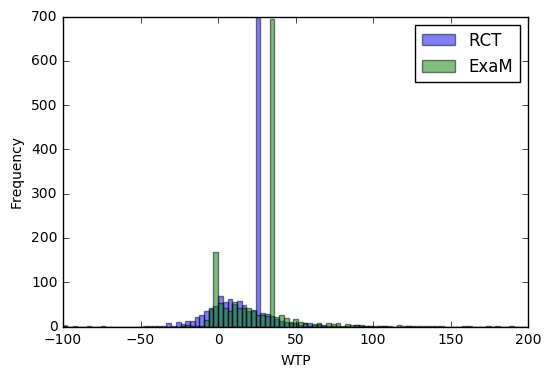

In [46]:
plt.clf()
bins = np.linspace(-100, 200, 100)
plt.hist(wtp_star_rct, bins=bins, label='RCT', alpha=0.5)
plt.hist(wtp_star_exam, bins=bins, label='ExaM', alpha=0.5)
plt.xlabel("WTP")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.savefig('output/WTP_plot_dataset_'+str(d)+'.png')
plt.show()

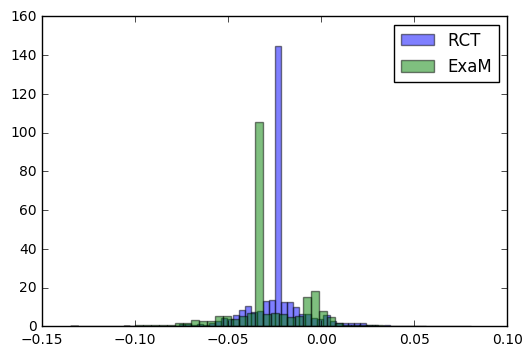

In [65]:
plt.hist(pte_star_rct, normed=True, bins=50, label='RCT', alpha=0.5)
plt.hist(pte_star_exam, normed=True, bins=50, label='ExaM', alpha=0.5)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# sanity check 
# subjects with same PTE & WTP should have the same demands

